In [1]:
import sys
sys.path.append('..')

import os

import cv2
import numpy as np
import pydicom
import matplotlib.pyplot as plt

from ipywidgets.widgets import interact, IntSlider, fixed
import ipywidgets as widgets

from src.visualisation import PatientSnapshot
from src.segmentation import threshold_segmentation
from src.segmentation import morph_snakes_segmentation
from src.utils import remove_legs, are_legs

If you use TorchIO for your research, please cite the following paper:

Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning
(https://arxiv.org/abs/2003.04696)


In [2]:
patient_path = '../data/1/'
patient = PatientSnapshot.from_path(patient_path, mask_path=None)

In [3]:
%%time

patient.snapshot = remove_legs(patient.snapshot)

CPU times: user 15.1 ms, sys: 9.73 ms, total: 24.8 ms
Wall time: 122 ms


## Threshold segmentation

In [4]:
%%time

mask = threshold_segmentation(patient.snapshot)
patient.mask = mask

CPU times: user 1.2 s, sys: 768 ms, total: 1.97 s
Wall time: 1.94 s


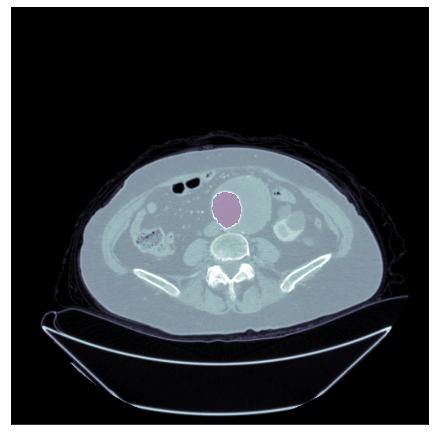

In [5]:
# Static plot
patient.horizontal_plot(z=200, vmin=-1000, vmax=500, plot_mask=True)

In [6]:
# Interactive plot
interact(patient.horizontal_plot, 
         z=IntSlider(min=0, max=patient.shape[0]-1, value=581, continious_update=False), 
         vmin=IntSlider(min=-1000, max=1000, value=-1000, continious_update=False), 
         vmax=IntSlider(min=-1000, max=1000, value=500, continious_update=False),
)

interactive(children=(IntSlider(value=536, description='z', max=536), IntSlider(value=-1000, description='vmin…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

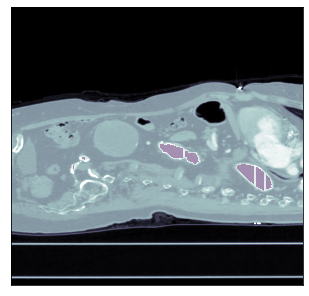

In [7]:
patient.longitudinal_plot(x=300, vmin=-1000, vmax=500, plot_mask=True)

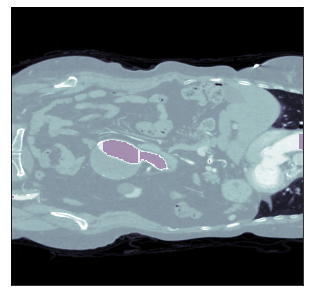

In [8]:
patient.frontal_plot(y=250, vmin=-1000, vmax=500, plot_mask=True)

In [9]:
# threshold = 300
# aspectratio = dict(x=1, y=1, z=1)
# patient.plot_3d(threshold, aspectratio=aspectratio)

## Morphological snakes segmentation

In [11]:
aneurism_center = (240, 280)
radius = 20
num_iterations = 250
balloon = 0  # толерантность к отсутствию градиента
z = 200
mask = morph_snakes_segmentation(patient.snapshot,
                                start_point=aneurism_center,
                                start_radius=radius,
                                num_iterations=num_iterations,
                                balloon=balloon,
                                z=z)
patient.mask = mask

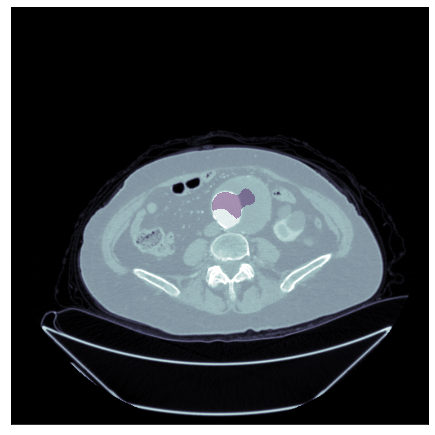

In [13]:
patient.horizontal_plot(z=200, vmin=-1000, vmax=500, plot_mask=True)

In [81]:
from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.segmentation import chan_vese
from skimage.segmentation import circle_level_set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Felzenszwalb number of segments: 1024
SLIC number of segments: 176
Quickshift number of segments: 695


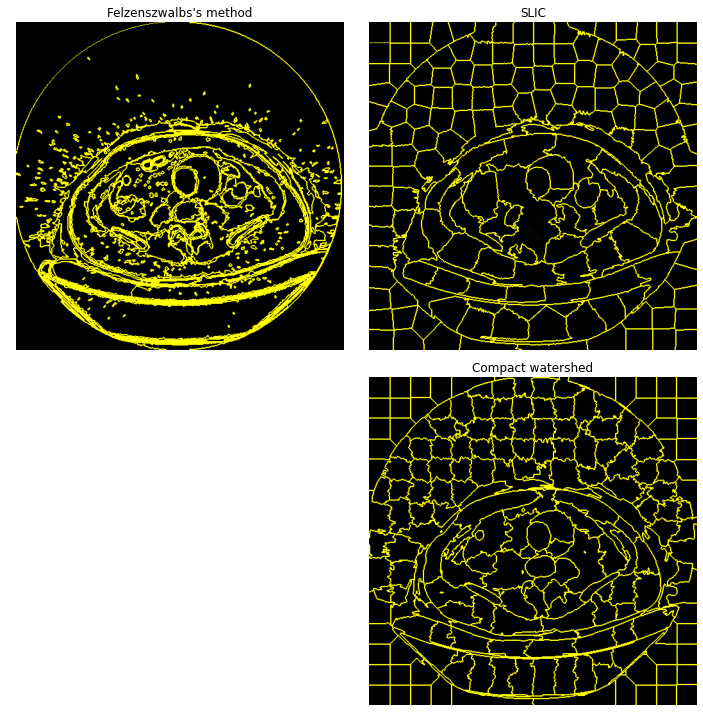

In [77]:
img = img_as_float(patient.snapshot[200])

segments_fz = felzenszwalb(img, scale=3, sigma=0.5, min_size=5)
segments_slic = slic(img, n_segments=250, compactness=0.001, sigma=0.5)
# segments_chan_vese = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200, dt=0.5, init_level_set="checkerboard", extended_output=True)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.00001)

print(f"Felzenszwalb number of segments: {len(np.unique(segments_fz))}")
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
# ax[1, 0].imshow(mark_boundaries(img, segments_chan_vese))
# ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

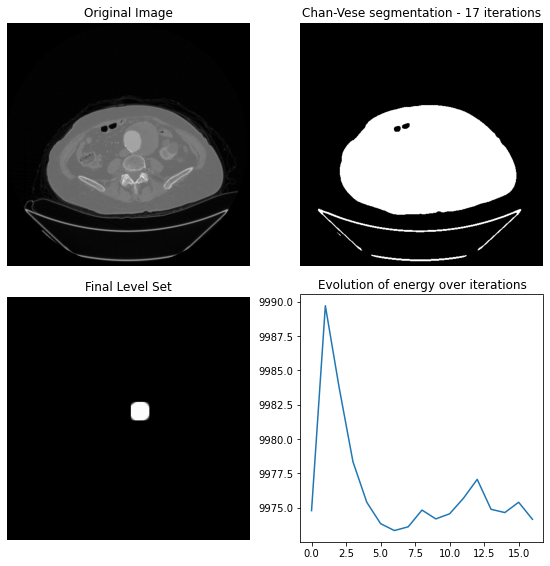

In [82]:
ls = circle_level_set(img.shape, (240, 280), 20)
cv = chan_vese(img, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=100,
               dt=0.5, init_level_set=ls, extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(img, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()